## <a name="E0">1. Loading and Cleaning Data

In this section, I will load the training data collected for Voice, DNS, Telnet, and Ping data from traffic_classifier.py script. I will clean the data for usability with the Machine Learning models.

#### Install necessary libraries
First I will install the necessary libraries to run the following code.

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install sklearn

#### Importing libraries
Then I will import the libraries I need to run the following code.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import pickle

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Filter warnings
import warnings
warnings.filterwarnings('ignore') #filter warnings
# Show plots inline
%matplotlib inline

#### Loading Data
Here I load the CSV data collected from the Python script into pandas dataframe

In [3]:
ping_df = pd.read_csv('ping_training_data.csv', delimiter='\t')
voice_df = pd.read_csv('voice_training_data.csv', delimiter='\t')
dns_df = pd.read_csv('dns_training_data.csv', delimiter='\t')
telnet_df = pd.read_csv('telnet_training_data.csv', delimiter='\t')
df = pd.concat([ping_df, voice_df, dns_df, telnet_df], ignore_index=True)

#### Cleaning Data
Drop any rows that contain NaN (this happens when the training script ends abruptly)

In [4]:
df.dropna(inplace=True)

Drop the Forward Packets, Forward Bytes, Reverse Packets, Reverse Bytes data. This data increases linearly and at a certain point in time can be any value so it is not helpful as a feature in the model. 

In [5]:
df.drop('Forward Packets', axis=1, inplace=True)
df.drop('Forward Bytes', axis=1, inplace=True)
df.drop('Reverse Packets', axis=1, inplace=True)
df.drop('Reverse Bytes', axis=1, inplace=True)

#### Describing Data

In [6]:
print(df.shape)

(5242, 13)


Now I have 5242 rows and 13 columns (12 features, 1 target)

I can take a look at basic statistical information about our data now.

In [7]:
df.describe()

,Delta Forward Packets,Delta Forward Bytes,Forward Instantaneous Packets per Second,Forward Average Packets per second,Forward Instantaneous Bytes per Second,Forward Average Bytes per second,Delta Reverse Packets,Delta Reverse Bytes,DeltaReverse Instantaneous Packets per Second,Reverse Average Packets per second,Reverse Instantaneous Bytes per Second,Reverse Average Bytes per second
count,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000
mean,7.814765,682.359214,7.763640,6.094360,677.842999,530.202926,17.525754,2070.781000,17.447921,15.710718,2064.795498,1943.829194
std,27.445539,2417.020821,27.343341,10.656380,2407.997270,937.773493,31.726859,3404.747532,31.645749,18.427478,3401.356026,2739.969899
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.909309,0.000000,62.009611,1.000000,71.000000,1.000000,1.020725,71.000000,98.670691
50%,1.000000,66.000000,1.000000,1.021459,66.000000,98.762821,1.000000,98.000000,1.000000,1.430508,98.000000,192.470941
75%,1.000000,98.000000,1.000000,1.038462,98.000000,99.485632,37.000000,3696.000000,37.000000,34.969697,3541.000000,2313.000000
max,211.000000,18581.000000,211.000000,76.750000,18581.000000,6711.000000,210.000000,15484.000000,210.000000,76.500000,15484.000000,7054.188679


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5242 entries, 0 to 5242
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Delta Forward Packets                          5242 non-null   int64  
 1   Delta Forward Bytes                            5242 non-null   int64  
 2   Forward Instantaneous Packets per Second       5242 non-null   float64
 3   Forward Average Packets per second             5242 non-null   float64
 4   Forward Instantaneous Bytes per Second         5242 non-null   float64
 5   Forward Average Bytes per second               5242 non-null   float64
 6   Delta Reverse Packets                          5242 non-null   float64
 7   Delta Reverse Bytes                            5242 non-null   float64
 8   DeltaReverse Instantaneous Packets per Second  5242 non-null   float64
 9   Reverse Average Packets per second             5242 

The type of the traffic column is object. I will convert this to a category so I can use `.cat` functionalities (Functions specific to categories).

In [9]:
df['Traffic Type'] = df['Traffic Type'].astype('category')

I can view all the types using `.cat.categories`:

In [10]:
df['Traffic Type'].cat.categories

Index(['dns', 'ping', 'telnet', 'voice'], dtype='object')

I can also get the data coded numerically using `.cat.codes`

In [11]:
df['Traffic Type'].cat.codes.head()

0    1
1    1
2    1
3    1
4    1
dtype: int8

The following features will be used in the model

In [12]:
print('Features:',df.columns[:-1].values)

Features: ['Delta Forward Packets' 'Delta Forward Bytes'
 'Forward Instantaneous Packets per Second'
 'Forward Average Packets per second'
 'Forward Instantaneous Bytes per Second'
 'Forward Average Bytes per second' 'Delta Reverse Packets'
 'Delta Reverse Bytes' 'DeltaReverse Instantaneous Packets per Second'
 'Reverse Average Packets per second'
 'Reverse Instantaneous Bytes per Second'
 'Reverse Average Bytes per second']


These are the counts of each type of traffic

In [13]:
print ('Value counts:')
df['Traffic Type'].value_counts()

Value counts:


ping      1770
telnet    1181
dns       1154
voice     1137
Name: Traffic Type, dtype: int64

## <a name="E1"> 2. Supervised Model - Logistic Regression 

Now I will train a logistic regression model on this dataset by splitting it into a training and testing set. 

#### Split dataset
First I will split the dataset into features and targets.

In [14]:
X = df.drop('Traffic Type',axis=1)
y = df['Traffic Type']

#### Create training and testing sets
I will use train_test_split with test size of 0.2 to put 80% of our data into training, and 20% into testing. The random_state is set so the results are repeatable.

In [15]:
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.2, random_state=744)

#### Train model
Now I will create and train the model.

In [16]:
model = LogisticRegression()

In [17]:
model.fit(train_x,train_y)

LogisticRegression()

#### Make predictions
Single prediction

In [18]:
idx = 2590 #random number
single_test_x = [df.iloc[idx].drop('Traffic Type').tolist()]
single_test_y = df.iloc[idx]['Traffic Type']

In [19]:
single_prediction = model.predict(single_test_x)
print('For this sample, our model predicted %s and it was actually %s' % (single_prediction[0], single_test_y))

For this sample, our model predicted voice and it was actually voice


Entire test set

In [20]:
predictions = model.predict(test_x)

I can create a dataframe to see these in table form:

In [21]:
resultsDF = pd.DataFrame({
        'true':test_y,
        'predicted':predictions
    })
resultsDF.head()

,true,predicted
1989,voice,voice
4199,telnet,telnet
80,ping,ping
3501,dns,dns
4687,telnet,telnet


In [22]:
print('Accuracy: %.2f%%' % (accuracy_score(predictions,test_y)*100))

Accuracy: 100.00%


I see the model has a <b>100.00%</b> accuracy

I can save the model using the pickle library to use later in real-time

In [23]:
print(pickle.format_version)

4.0


In [24]:
pickle.dump(model,open('LogisticRegression','wb'))

#### Confusion Matrix
The confusion matrix allows you to see the numerical breakdown of the predictions by class:

In [25]:
cm = confusion_matrix(predictions,test_y, labels=y.cat.categories)
print(cm)

[[238   0   0   0]
 [  0 353   0   0]
 [  0   0 219   0]
 [  0   0   0 239]]


To attach labels, I can view it as a dataframe:

In [26]:
cmDF = pd.DataFrame()

for i, row in enumerate(y.cat.categories):
    temp = {}
    for j, col in enumerate(y.cat.categories): 
        temp[col]=cm[i,j]
    cmDF = cmDF.append(pd.DataFrame.from_dict({row:temp}, orient='index'))

print(cmDF)

        dns  ping  telnet  voice
dns     238     0       0      0
ping      0   353       0      0
telnet    0     0     219      0
voice     0     0       0    239


I can also add a heatmap to better visualize it

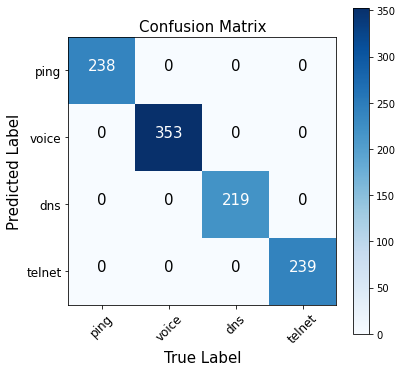

In [27]:
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, y.unique(), rotation=45, fontsize=12)
plt.yticks(tick_marks, y.unique(), fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 5:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)


I can see the model works well for all classes.

#### Principal Component Analysis

Principal Component Analysis (PCA) is a dimension reduction technique. It decomposes your data into principal components where each principal component tries to explain as much variance left as possible in the data, in decending order. E.g., PC1 will explain as much variance as possible, PC2 will try to explain as much of the variance left as possible after the PC1 rotation is applied and so on. Each principal component is a combination of your existing components.

This will allow us to visualize this higher dimensional data in a lower dimensional space.

#### Normalize data
Here I will scale the data so that they are within the same range. For PCA to work correctly and find the right covariance amongst all the features we need to scale the data so that they are within the same range. This will keep one feature from contributing more to the final components.

The StandardScaler class from sklearn will remove the mean and scale the data so the have unit variance.

In [28]:
df.drop('Traffic Type',axis=1).values[0:5]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 1. , 98. ,  1. ,  1. , 98. , 98. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 1. , 98. ,  1. ,  1. , 98. , 98. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 1. , 98. ,  1. ,  1. , 98. , 98. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ],
       [ 1. , 98. ,  1. ,  1. , 98. , 98. ,  1. , 98. ,  1. ,  0.5, 98. ,
        49. ]])

Here are the means/std per feature.

In [29]:
df.drop('Traffic Type',axis=1).values.mean(axis=0)

array([   7.81476536,  682.35921404,    7.76363983,    6.09435952,
        677.84299886,  530.2029264 ,   17.52575353, 2070.78099962,
         17.44792064,   15.71071753, 2064.7954979 , 1943.8291939 ])

In [30]:
df.drop('Traffic Type',axis=1).values.std(axis=0)

array([  27.44292102, 2416.7902663 ,   27.34073283,   10.65536331,
       2407.76757632,  937.68404081,   31.72383282, 3404.4227598 ,
         31.64272994,   18.42572049, 3401.03157782, 2739.70853918])

Here, i fit the scaler.

In [31]:
scaler = StandardScaler()
scaler.fit(df.drop('Traffic Type',axis=1))

StandardScaler()

In [32]:
scaled_data = scaler.transform(df.drop('Traffic Type',axis=1))
scaled_data[0:5]

array([[-0.28476434, -0.2823411 , -0.28395873, -0.5719523 , -0.28152344,
        -0.56543879, -0.55244754, -0.608262  , -0.55140377, -0.85265146,
        -0.60710859, -0.70950218],
       [-0.24832507, -0.24179145, -0.24738327, -0.47810285, -0.24082183,
        -0.46092597, -0.55244754, -0.608262  , -0.55140377, -0.85265146,
        -0.60710859, -0.70950218],
       [-0.24832507, -0.24179145, -0.24738327, -0.47810285, -0.24082183,
        -0.46092597, -0.55244754, -0.608262  , -0.55140377, -0.85265146,
        -0.60710859, -0.70950218],
       [-0.24832507, -0.24179145, -0.24738327, -0.47810285, -0.24082183,
        -0.46092597, -0.55244754, -0.608262  , -0.55140377, -0.85265146,
        -0.60710859, -0.70950218],
       [-0.24832507, -0.24179145, -0.24738327, -0.47810285, -0.24082183,
        -0.46092597, -0.5209255 , -0.57947592, -0.51980094, -0.82551548,
        -0.57829381, -0.69161707]])

Here are the new means and standard deviation per feature.

In [33]:
scaled_data.mean(axis=0)

array([ 0.00000000e+00, -2.16876837e-17,  0.00000000e+00,  1.73501469e-16,
       -2.16876837e-17,  0.00000000e+00, -5.42192091e-17,  3.25315255e-17,
        3.25315255e-17, -5.42192091e-17, -9.21726555e-17, -2.16876837e-17])

In [34]:
scaled_data.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Now I will fit PCA model to the data. I will specify n_components=2, because I only want the first 2 principal components.

In [35]:
pca = PCA(n_components=2)
pca.fit(scaled_data)

PCA(n_components=2)

In [36]:
scaled_data.shape

(5242, 12)

In [37]:
x_pca = pca.transform(scaled_data)

In [38]:
x_pca.shape

(5242, 2)

#### Explained Variance

In [39]:
pca.explained_variance_ratio_

array([0.5646886, 0.2769479])

In [40]:
pca.explained_variance_ratio_.sum()*100

84.16364984328655

From above you can see that our first 2 principal components explain 84.16% of the variance in our data. I can get higher variance explained by increasing the number of principal components to a maximum of 100% with n_components = n_features.

#### Plotting the principal components

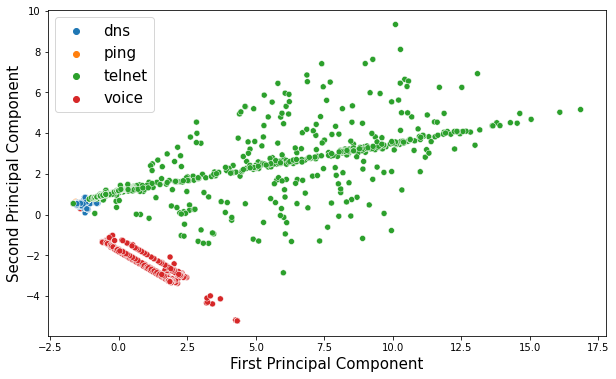

In [41]:
fig = plt.figure(figsize=(10,6))
sns.scatterplot(x_pca[:,0], x_pca[:,1], hue=df['Traffic Type'])
plt.xlabel('First Principal Component', fontsize=15)
plt.ylabel('Second Principal Component', fontsize=15)
plt.legend(fontsize=15)

From this plot, I can see voice and ping are easy to identify using first 2 principle components. Ping and DNS are difficult. That is why I use all the features in our data not just first two components. 

#### Decision Boundary w/ PCA
The decision boundary is where the model switches from predicting one class to another. For visual representation purposes, I will again use the principal components I computed above for training. This way I can train a model with 2 features, and visualize the decision boundary in 2D space. However, the real model will use all the features and so the decision boundary may be different. 

I will follow the same steps as above for training a model. I use the coded y as the contour plot that we use below prefers numerical values.

In [42]:
train_x, test_x, train_y, test_y = train_test_split(x_pca,y.cat.codes,test_size=0.3, random_state=101)

In [43]:
model = LogisticRegression()
model.fit(train_x,train_y)

LogisticRegression()

As discussed above, the accuracy value is lower when I only use the first 2 principle components as opposed to the full set of features. Again, this is just for visualization purposes.

In [44]:
predictions = model.predict(test_x)
print('Accuracy: %.2f%%' % (accuracy_score(predictions,test_y)*100))

Accuracy: 88.87%


#### Plotting
I will first generate a grid of x[0] and x[1] values that I will use to make predictions with.

In [45]:
x_min = x_pca[:,0].min()
x_max = x_pca[:,0].max()
y_min = x_pca[:,1].min()
y_max = x_pca[:,1].max()
spacing = 0.01

In [46]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, spacing), np.arange(y_min, y_max, spacing))

Now I will make predictions on the grid that I created. The `ravel` function just makes the 2D array that we have above into a 1D array. I will reshape the predictions Z into a 2D array afterwards for plotting

In [47]:
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Now I will plot the data, and the decision boundaries.

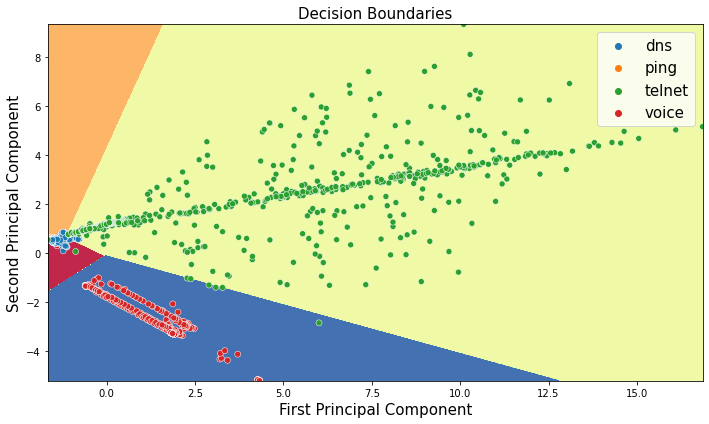

In [48]:
plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
sns.scatterplot(x_pca[:,0], x_pca[:,1], hue=df['Traffic Type'], cmap=plt.cm.Spectral)
plt.title('Decision Boundaries', fontsize=15)
plt.xlabel('First Principal Component', fontsize=15)
plt.ylabel('Second Principal Component', fontsize=15)
plt.tight_layout()
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.legend(fontsize=15)

From the above you can see the decision splits. Voice and Telnet traffic are easily classifiable. Ping and DNS are harder to distinguish with only 2 components. 

## <a name="E2"> 3. Unsupervised Model - K-Means Clustering

Now I will train a K-means clustering model on this dataset.

#### Build model
Here I will build a `sklearn KMeans` model with 4 possible clusters for each type of traffic:

In [49]:
x = df.drop('Traffic Type',axis=1)
y = df['Traffic Type']

In [50]:
modelknn = KMeans(n_clusters=len(y.cat.categories))

#### Train & predict

In [51]:
clusters = modelknn.fit_predict(x)

#### Evaluate generated clusters

#### Shape of clusters

In [52]:
modelknn.cluster_centers_.shape

(4, 12)

I see that there are 4 clusters in 12 dimensions. 

### Visualize clusters

Let's visualize each of these cluster centers to see what they represent. The 12 size vector is reshaped into a 4x3, and visualized using matplotlib.

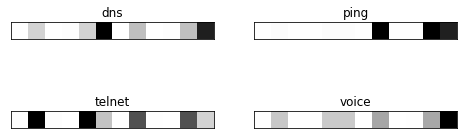

In [53]:
fig = plt.figure(figsize=(8, 3))
for i in range(len(y.cat.categories)):
    ax = fig.add_subplot(2, 2, 1 + i, xticks=[], yticks=[])
    ax.set_title(str(y.cat.categories[i]))
    ax.imshow(modelknn.cluster_centers_[i].reshape((1, 12)), cmap=plt.cm.binary)

From the above I can see which features Kmeans looks for to differentiate the traffic types

Dumping the model for real-time use later

In [54]:
pickle.dump(modelknn,open('KMeans_Clustering','wb'))